<font size="+3"><strong>3.3. Autoregressive Models</strong></font>

In [69]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

warnings.simplefilter(action="ignore", category=FutureWarning)

In [70]:
from IPython.display import VimeoVideo

In [71]:
VimeoVideo("665851858", h="e39fc3d260", width=600)

# Prepare Data

## Import

In [3]:
VimeoVideo("665851852", h="16aa0a56e6", width=600)

**Task 3.3.1:** Complete to the create a client to connect to the MongoDB server, assigns the `"air-quality"` database to `db`, and assigned the `"nairobi"` connection to `nairobi`.

- [<span id='technique'>Create a client object for a <span id='tool'>MongoDB</span> instance.](../%40textbook/11-databases-mongodb.ipynb#Servers-and-Clients) 
- [<span id='technique'>Access a database using <span id='tool'>PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Servers-and-Clients)
- [<span id='technique'>Access a collection in a database using <span id='tool'>PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Collections)

In [4]:
client = MongoClient(host="localhost",port=27017)
db = client["air-quality"]
nairobi = db["nairobi"]

In [5]:
VimeoVideo("665851840", h="e048425f49", width=600)

**Task 3.3.2:** Change the `wrangle` function below so that it returns a Series of the resampled data instead of a DataFrame.

In [72]:
def wrangle(collection):
    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read data into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["P2"].resample("1H").mean().fillna(method='ffill')

    return y

**Task 3.3.3:** Use your wrangle function to read the data from the `nairobi` collection into the Series `y`.

In [73]:
y = wrangle(nairobi)
y.head()

timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

In [74]:
# Check your work
assert isinstance(y, pd.Series), f"`y` should be a Series, not type {type(y)}"
assert len(y) == 2928, f"`y` should have 2928 observations, not {len(y)}"
assert y.isnull().sum() == 0

## Explore

In [14]:
VimeoVideo("665851830", h="85f58bc92b", width=600)

**Task 3.3.4:** Create an ACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`.

- [What's an <span id='term'>ACF plot?](../%40textbook/17-ts-core.ipynb#ACF-Plot)
- [<span id='technique'>Create an ACF plot using <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#Creating-an-ACF-Plot)

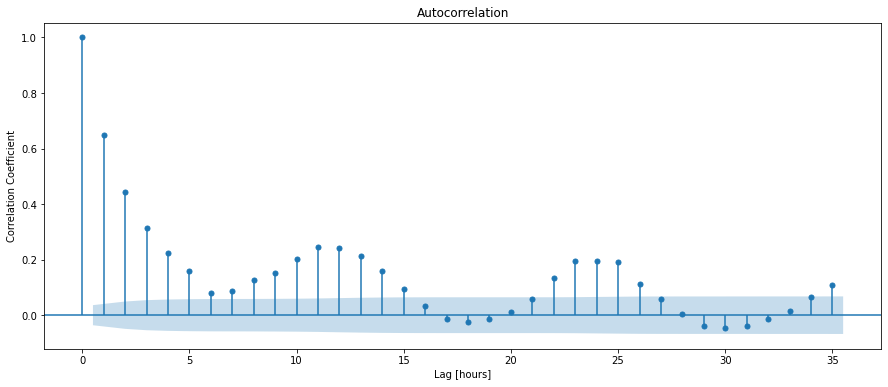

In [75]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

In [23]:
VimeoVideo("665851811", h="ee3a2b5c24", width=600)

In [25]:
y.shift(1).corr(y.shift(2))

0.6506810900745511

**Task 3.3.5:** Create an PACF plot for the data in `y`. Be sure to label the x-axis as `"Lag [hours]"` and the y-axis as `"Correlation Coefficient"`.

- [What's an <span id='term'>PACF plot?](../%40textbook/17-ts-core.ipynb#PACF-Plot)
- [<span id='technique'>Create an PACF plot using <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#Creating-a-PACF-Plot)

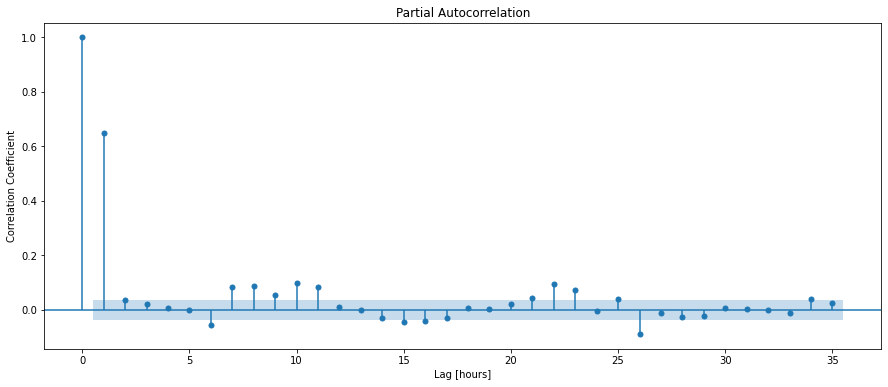

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

## Split

In [27]:
VimeoVideo("665851798", h="6c191cd94c", width=600)

**Task 3.3.6:** Split `y` into training and test sets. The first 95% of the data should be in your training set. The remaining 5% should be in the test set.

- [<span id='technique'>Divide data into training and test sets in <span id='tool'>pandas.](../%40textbook/18-ts-models.ipynb#Splitting-the-Data-in-pandas)

In [76]:
cutoff = int(len(y)*0.95)

y_train = y.iloc[:cutoff]
y_test =  y.iloc[cutoff:]
print(len(y_train))

2781


# Build Model

## Baseline

**Task 3.3.7:** Calculate the baseline mean absolute error for your model.

- [<span id='technique'>Calculate summary statistics for a DataFrame or Series in <span id='tool'>pandas.](../%40textbook/04-pandas-advanced.ipynb#Calculate-Summary-Statistics-for-a-DataFrame-or-Series)

In [77]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.22
Baseline MAE: 3.71


## Iterate

In [32]:
VimeoVideo("665851769", h="94a4296cde", width=600)

**Task 3.3.8:** Instantiate an [`AutoReg`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AutoReg.html) model and fit it to the training data `y_train`. Be sure to set the `lags` argument to `26`.

- [What's an <span id='term'>AR model?](../%40textbook/17-ts-core.ipynb#Autoregression-Models)
- [<span id='technique'>Instantiate a predictor in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Splitting-the-Data-in-pandas)
- [<span id='technique'>Train a model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)

In [78]:
model = AutoReg(y_train,lags=26).fit()

In [35]:
VimeoVideo("665851746", h="1a4511e883", width=600)

**Task 3.3.9:** Generate a list of training predictions for your model and use them to calculate your training mean absolute error. 

- [<span id='technique'>Generate in-sample predictions for a model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Iterating)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [79]:
model.predict().isnull().sum()

26

In [80]:
y_pred = model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.2809871656467036


In [42]:
VimeoVideo("665851744", h="60d053b455", width=600)

**Task 3.3.10:** Use `y_train` and `y_pred` to calculate the residuals for your model.

- [What's a <span id='term'>residual?](../%40textbook/12-ml-core.ipynb#Residuals)
- [<span id='technique'>Create new columns derived from existing columns in a DataFrame using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Adding-Columns)

In [82]:
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2018-12-25 19:00:00+03:00   -0.392002
2018-12-25 20:00:00+03:00   -1.573180
2018-12-25 21:00:00+03:00   -0.735747
2018-12-25 22:00:00+03:00   -2.022221
2018-12-25 23:00:00+03:00   -0.061916
Freq: H, dtype: float64

In [45]:
VimeoVideo("665851712", h="9ff0cdba9c", width=600)

**Task 3.3.11:** Create a plot of `y_train_resid`.

- [<span id='technique'>Create a line plot using <span id='tool'>pandas.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

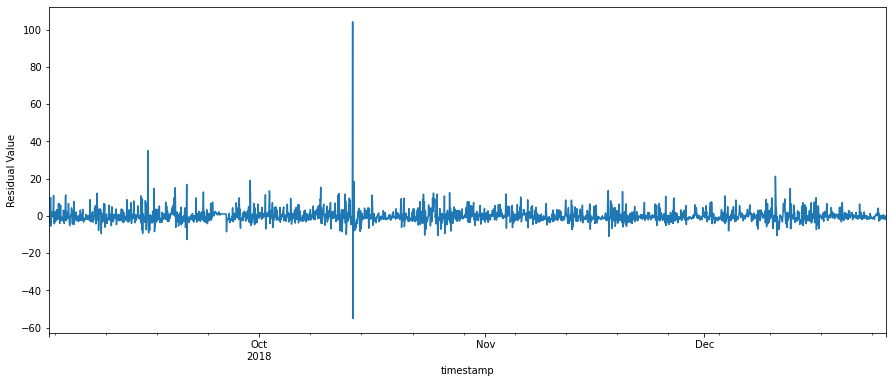

In [83]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax = ax);

In [47]:
VimeoVideo("665851702", h="b494adc297", width=600)

**Task 3.3.12:** Create a histogram of `y_train_resid`.

- [<span id='technique'>Create a histogram using <span id='tool'>plotly express.](../%40textbook/06-visualization-matplotlib.ipynb#Histograms)

Text(0.5, 1.0, 'AR(26), Distribution of Residuals')

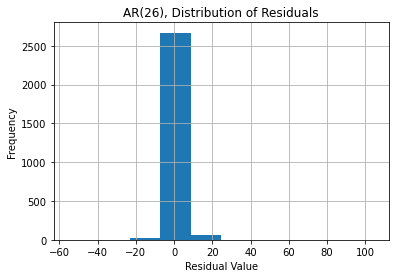

In [84]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residuals")

In [50]:
VimeoVideo("665851684", h="d6d782a1f3", width=600)

**Task 3.3.13:** Create an ACF plot of `y_train_resid`.

- [What's an <span id='term'>ACF plot?](../%40textbook/17-ts-core.ipynb#ACF-Plot)
- [<span id='technique'>Create an ACF plot using <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#ACF-Plots)

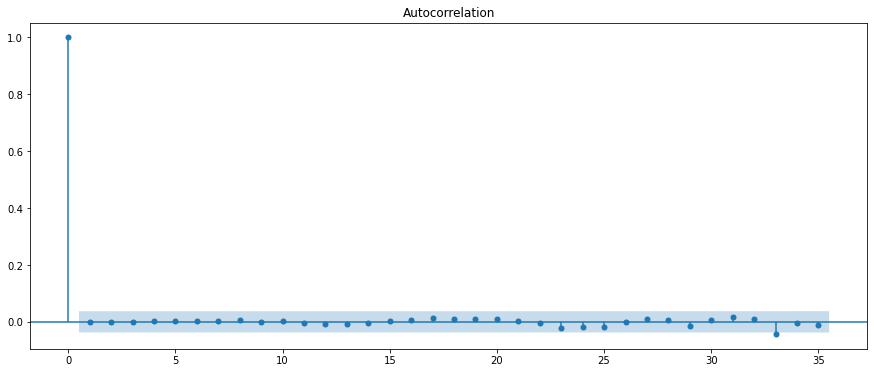

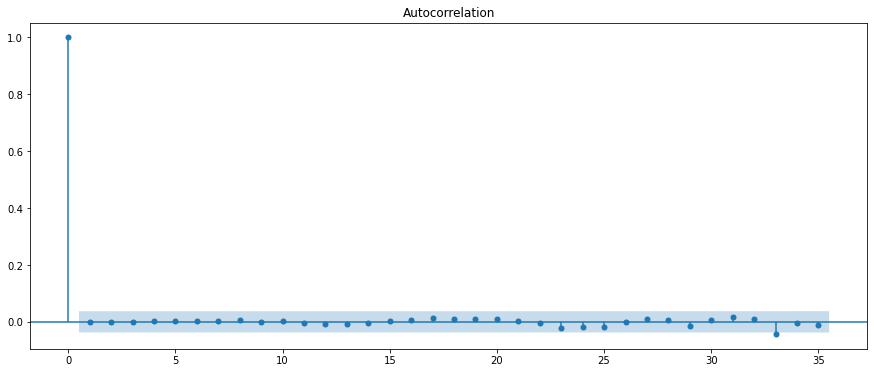

In [85]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)

## Evaluate

In [52]:
VimeoVideo("665851662", h="72e767e121", width=600)

In [86]:
y_test.index.min()

Timestamp('2018-12-26 00:00:00+0300', tz='Africa/Nairobi', freq='H')

**Task 3.3.14:** Calculate the test mean absolute error for your model.

- [<span id='technique'>Generate out-of-sample predictions using model in <span id='tool'>statsmodels.](../%40textbook/18-ts-models.ipynb#Out-of-Sample-Predictions)
- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [87]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 3.0136439495039054


**Task 3.3.15:** Create a DataFrame `test_predictions` that has two columns: `"y_test"` and `"y_pred"`. The first should contain the true values for your test set, and the second should contain your model's predictions. Be sure the index of `test_predictions` matches the index of `y_test`.

- [<span id='technique'>Create a DataFrame from a dictionary using <span id='tool'>pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)

In [88]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

In [57]:
VimeoVideo("665851628", h="29b43e482e", width=600)

**Task 3.3.16:** Create a time series plot for the values in `test_predictions` using plotly express. Be sure that the y-axis is properly labeled as `"P2"`.

- [<span id='technique'>Create a line plot in <span id='tool'>plotly express.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

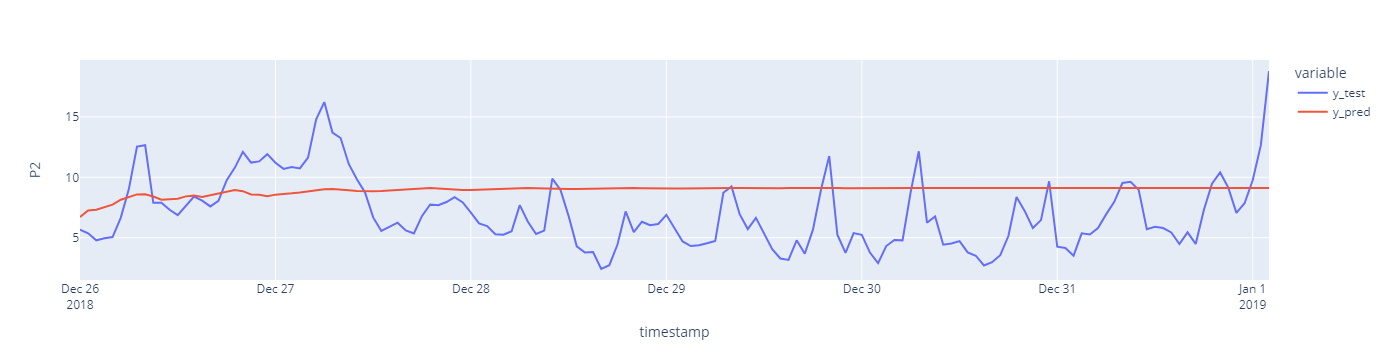

In [89]:
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

In [91]:
VimeoVideo("665851599", h="bb30d96e43", width=600)

**Task 3.3.17:** Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. 

- [What's <span id='term'>walk-forward validation?](../%40textbook/17-ts-core.ipynb#Walk-Forward-Validation)
- [<span id='technique'>Perform walk-forward validation for time series model.](../%40textbook/18-ts-models.ipynb#Walk-forward-Validation)

In [94]:
print(len(y_test))

147


In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()

for i in range(len(y_test)):
    print(i, end='\r', flush=True)
    model=AutoReg(history,lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])
    

In [98]:
len(y_pred_wfv)

147

In [61]:
history.tail(1)

timestamp
2018-12-25 23:00:00+03:00    6.422727
Freq: H, Name: P2, dtype: float64

In [64]:
y_test.head(1)

timestamp
2018-12-26 00:00:00+03:00    5.679091
Freq: H, Name: P2, dtype: float64

In [99]:
VimeoVideo("665851568", h="a764ab5416", width=600)

**Task 3.3.18:** Calculate the test mean absolute error for your model.

- [<span id='technique'>Calculate the mean absolute error for a list of predictions in <span id='tool'>scikit-learn.](../%40textbook/15-ml-regression.ipynb#Calculating-the-Mean-Absolute-Error-for-a-List-of-Predictions)

In [100]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.4


# Communicate Results

In [101]:
VimeoVideo("665851553", h="46338036cc", width=600)

**Task 3.3.19:** Print out the parameters for your trained model.

- [<span id='technique'>Access model parameters in <span id='tool'>statsmodels](../%40textbook/18-ts-models.ipynb#Communicating-the-Results)

In [103]:
print(model.params)

intercept    2.011432
P2.L1        0.587118
P2.L2        0.019796
P2.L3        0.023615
P2.L4        0.027187
P2.L5        0.044014
P2.L6       -0.102128
P2.L7        0.029583
P2.L8        0.049867
P2.L9       -0.016897
P2.L10       0.032438
P2.L11       0.064360
P2.L12       0.005987
P2.L13       0.018375
P2.L14      -0.007636
P2.L15      -0.016075
P2.L16      -0.015953
P2.L17      -0.035444
P2.L18       0.000756
P2.L19      -0.003907
P2.L20      -0.020655
P2.L21      -0.012578
P2.L22       0.052499
P2.L23       0.074229
P2.L24      -0.023806
P2.L25       0.090577
P2.L26      -0.088323
dtype: float64


In [104]:
VimeoVideo("665851529", h="39284d37ac", width=600)

**Task 3.3.20:** Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express.

- [<span id='technique'>Create a line plot in <span id='tool'>plotly express.](../%40textbook/07-visualization-pandas.ipynb#Line-Plots)

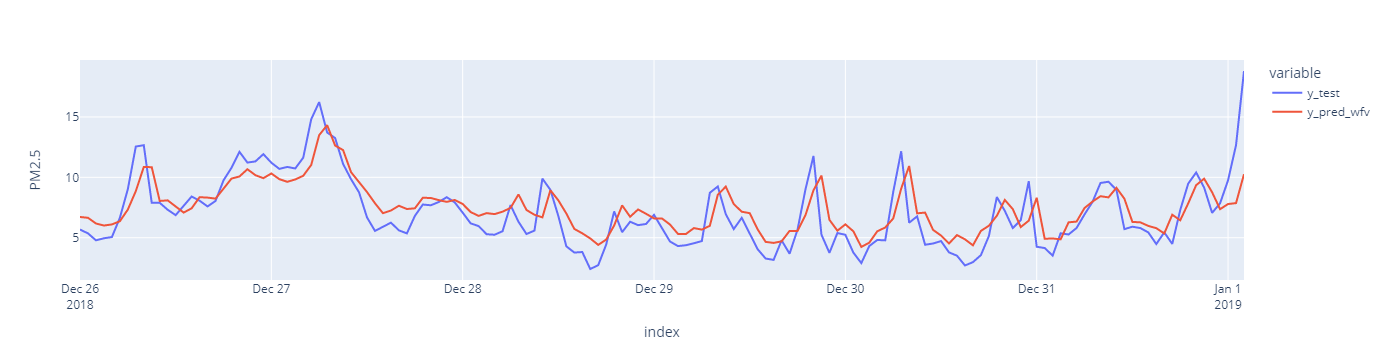

In [106]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred_wfv":y_pred_wfv}
)
fig = px.line(df_pred_test,labels={"value":"PM2.5"})
fig.show()

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
